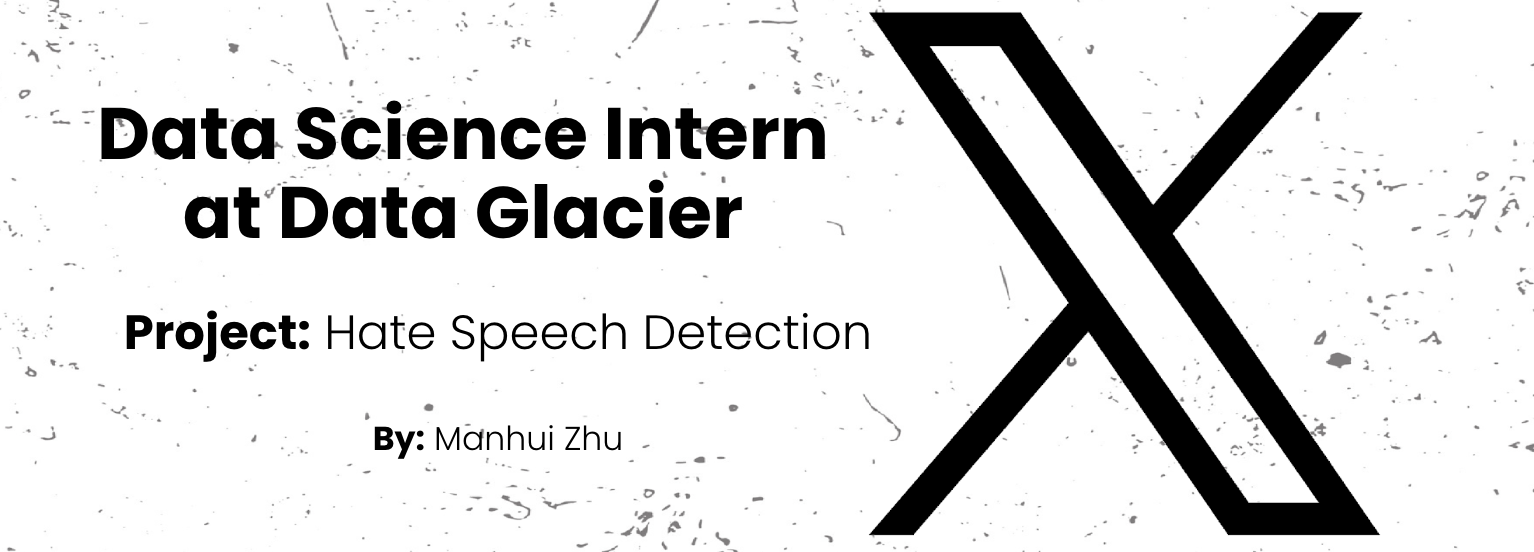

# Problem Statement

The term hate speech is understood as any type of verbal, written or behavioural communication that attacks or uses derogatory or discriminatory language against a person or group based on what they are, in other words, based on their religion, ethnicity, nationality, race, colour, ancestry, sex or another identity factor. In this problem, I will take you through a hate speech detection model with Machine Learning and Python.

Hate Speech Detection is generally a task of sentiment classification. A model that can classify hate speech from a certain piece of text can be achieved by training it on a data that is generally used to classify sentiments. So for the task of hate speech detection model, I will use the Twitter tweets to identify tweets containing  Hate speech.



$\rule{800pt}{20pt}$

# 1. Import libraries and datadet

## 1.1 Import libraries and packages

In [3]:
# Load All Packages

# Basic
import os
import pandas as pd
import numpy as np
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt

# Data preprocessing
import re
import string
import nltk

# EDA
from itertools import chain
from collections import Counter
from wordcloud import WordCloud
from sklearn.utils import resample

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, KeyedVectors
from transformers import BertTokenizer, BertModel
import torch

## 1.2 Import Dataset

In [6]:
# Navigate to Directory
drive.mount('/content/drive')

os.chdir("/content/drive/MyDrive/Data Glacier")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.3 Read the data

In [7]:
filepath = './Week 7-13: Hate Speech Detection Project (NLP)/'

speech = pd.read_csv(filepath + 'hate_speech.csv')

In [8]:
speech.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
speech.tail()

,id,label,tweet
31957,31958,0,ate @user isz that youuu?ðððððð...
31958,31959,0,to see nina turner on the airwaves trying to...
31959,31960,0,listening to sad songs on a monday morning otw...
31960,31961,1,"@user #sikh #temple vandalised in in #calgary,..."
31961,31962,0,thank you @user for you follow


## 1.3 Data information: number of columns and observatons, data type

In [6]:
speech.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      31962 non-null  int64 
 1   label   31962 non-null  int64 
 2   tweet   31962 non-null  object
dtypes: int64(2), object(1)
memory usage: 749.2+ KB


In [ ]:
speech.shape

(31962, 3)

There are 31962 tweets and 3 variables in the dataset.

## 1.4 Check the missing values and duplicated values

In [ ]:
speech.isnull().sum()

id       0
label    0
tweet    0
dtype: int64

In [ ]:
speech.duplicated().sum()

0

There is no missing values in our dataset, and each row has unique value.

$\rule{800pt}{20pt}$

# 2. Data Preprocessing

## 2.1 Text Cleaning

We can use the Regular Expression (`re`) package to help remove URLs and user mention and other special characters.

*   **Lowercasing**: Convert text to lowercase to ensure uniformity
*   **Remove User Mentions**: Strip out Twitter handles (eg. `@user`)
*   **Remove URLs**: Strip out URLs from the tweets
*   **Remove Special Characters**: Remove punctuation, special characters
*   **Remove leading and trailing whitespace**




In [9]:
def clean_tweet(tweet):
  '''Text Cleaning'''
  tweet = tweet.lower()      # lowercase
  tweet = re.sub(r'@[\w]*', '', tweet)     # remove @user
  # [\w]: a character class that matches any alphanumeric character
  # or underscore (equivalent to [A-Za-z0-9_])
  # *: a quantifier that matches zero or more occurrences of the preceding character class.

  tweet = re.sub(r'http\S+', '', tweet)    # remove URLs
  # http: Matches the literal string "http".
  # \S: Matches any non-whitespace character.
  # +: Quantifier that matches one or more of the preceding token (non-whitespace characters)

  special_chars = r'[^a-zA-Z\s]'  # Keep only letters, and whitespace
  tweet = re.sub(special_chars, '', tweet)     # remove digits and special characters

  tweet = tweet.strip()     # Remove leadind and trailing whitespace

  return tweet


In [10]:
speech['tweet'] = speech['tweet'].apply(clean_tweet)

## 2.2 Remove stop words

Remove words that appeared frequently like 'and', 'is', 'the' but may not contribute to the meaning of the sentence. We use the `nltk` library and download thr stop words list to remove stop words.

In [11]:
from nltk.corpus import stopwords
nltk.download('stopwords')

# get the list of enligh stop words
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
def remove_stop_words(tokens):
    return [word for word in tokens if word not in stop_words]

In [13]:
speech['nostop_tweet'] = speech['tweet'].apply(lambda x: ' '.join(remove_stop_words(x.split())))

In [12]:
speech.head()

,id,label,tweet,nostop_tweet
0,1,0,when a father is dysfunctional and is so selfi...,father dysfunctional selfish drags kids dysfun...
1,2,0,thanks for lyft credit i cant use cause they d...,thanks lyft credit cant use cause dont offer w...
2,3,0,bihday your majesty,bihday majesty
3,4,0,model i love u take with u all the time in ur,model love u take u time ur
4,5,0,factsguide society now motivation,factsguide society motivation


## 2.3 Tokenization

Split tweets into individual words (tokens)

In [14]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')

speech['tokenized_tweet'] = speech['nostop_tweet'].apply(word_tokenize)
speech.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,id,label,tweet,nostop_tweet,tokenized_tweet
0,1,0,when a father is dysfunctional and is so selfi...,father dysfunctional selfish drags kids dysfun...,"[father, dysfunctional, selfish, drags, kids, ..."
1,2,0,thanks for lyft credit i cant use cause they d...,thanks lyft credit cant use cause dont offer w...,"[thanks, lyft, credit, cant, use, cause, dont,..."
2,3,0,bihday your majesty,bihday majesty,"[bihday, majesty]"
3,4,0,model i love u take with u all the time in ur,model love u take u time ur,"[model, love, u, take, u, time, ur]"
4,5,0,factsguide society now motivation,factsguide society motivation,"[factsguide, society, motivation]"


## 2.4 Lemmatization

Reduce words to their base or root form by considering the context meaning of the word. It uses a dictionary-based approach to return the lemma, which is the base form of a word.

In [15]:
from textblob import Word
nltk.download('wordnet')

speech['clean_tweet'] = speech['nostop_tweet'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:
speech.head()

,id,label,tweet,nostop_tweet,tokenized_tweet,clean_tweet
0,1,0,when a father is dysfunctional and is so selfi...,father dysfunctional selfish drags kids dysfun...,"[father, dysfunctional, selfish, drags, kids, ...",father dysfunctional selfish drag kid dysfunct...
1,2,0,thanks for lyft credit i cant use cause they d...,thanks lyft credit cant use cause dont offer w...,"[thanks, lyft, credit, cant, use, cause, dont,...",thanks lyft credit cant use cause dont offer w...
2,3,0,bihday your majesty,bihday majesty,"[bihday, majesty]",bihday majesty
3,4,0,model i love u take with u all the time in ur,model love u take u time ur,"[model, love, u, take, u, time, ur]",model love u take u time ur
4,5,0,factsguide society now motivation,factsguide society motivation,"[factsguide, society, motivation]",factsguide society motivation


# 3. EDA (Exploratory Data Analysis)

## 3.1 Number of words in tweet & number of stop words in tweet

In [ ]:
# Number of words in tweet

df = pd.DataFrame()

df['tweet'] = speech['tweet']
df['word_count'] = speech['tweet'].apply(lambda x: len(str(x).split(" ")))

In [ ]:
# Number of stop words in tweet

df['stopwords_count'] = df['tweet'].apply(lambda x:
                                          len([x for x in x.split() if x in stop_words]))
df.head()

,tweet,word_count,stopwords_count
0,when a father is dysfunctional and is so selfi...,19,10
1,thanks for lyft credit i cant use cause they d...,20,4
2,bihday your majesty,3,1
3,model i love u take with u all the time in ur,14,5
4,factsguide society now motivation,7,1


In [ ]:
df['word_count'].max()

43

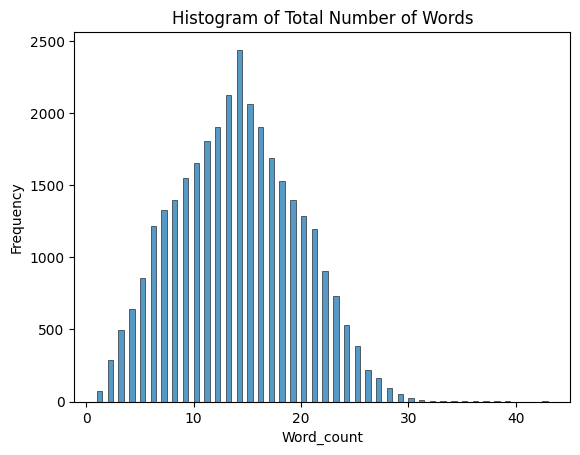

In [ ]:
# Histogram of total number of words

sns.histplot(df['word_count'])
plt.title('Histogram of Total Number of Words')
plt.xlabel('Word_count')
plt.ylabel('Frequency')
plt.show()

## 3.2 The most frequent words in the whole dataset

In [ ]:
# Flatten the list of tokenized tweets
all_tokens = list(chain.from_iterable(speech['tokenized_tweet']))

# Count word frequencies
word_counts = Counter(all_tokens)

# Top 10 most frequent words
word_counts.most_common(10)

[('love', 2726),
 ('day', 2290),
 ('happy', 1691),
 ('amp', 1608),
 ('im', 1157),
 ('u', 1148),
 ('life', 1127),
 ('time', 1126),
 ('like', 1053),
 ('today', 1008)]

<ipython-input-169-960f32ac4441>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x = 'frequency', y = 'word',


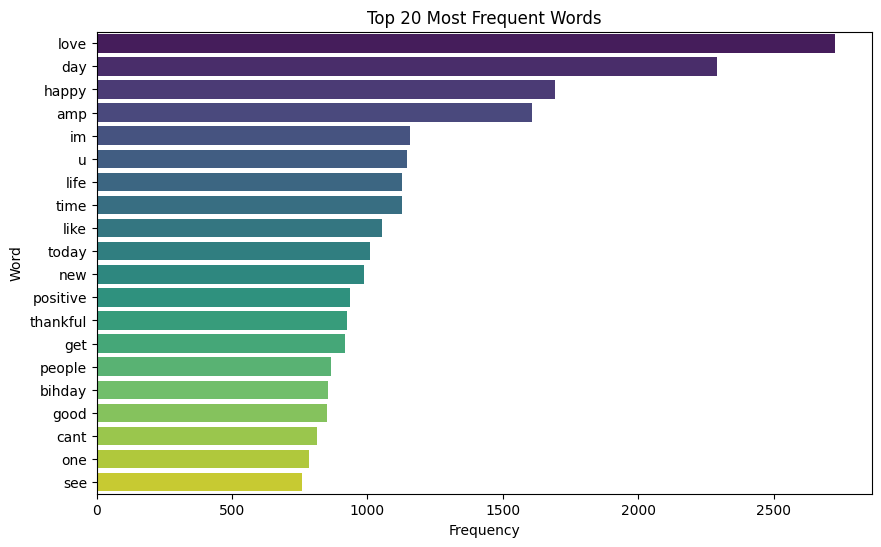

In [ ]:
word_freq = pd.DataFrame(word_counts.most_common(20),
                         columns = ['word', 'frequency'])

plt.figure(figsize = (10, 6))
sns.barplot(x = 'frequency', y = 'word',
            data = word_freq,
            palette = 'viridis')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

## 3.3 The most frequent words in hate tweets and non-hate tweets

In [ ]:
df = speech[['id', 'label', 'tokenized_tweet']]

group_df = df.groupby('label')['tokenized_tweet']

In [ ]:
# Create a dictionary to store word counts for each label
word_counts_by_label = {}

for label, tweets in group_df:
    all_tokens = list(chain.from_iterable(tweets))
    word_counts = Counter(all_tokens)
    word_counts_by_label[label] = word_counts

<ipython-input-172-e427d2d64f93>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data = nonhate_df,
<ipython-input-172-e427d2d64f93>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='frequency', y='word', data = hate_df,


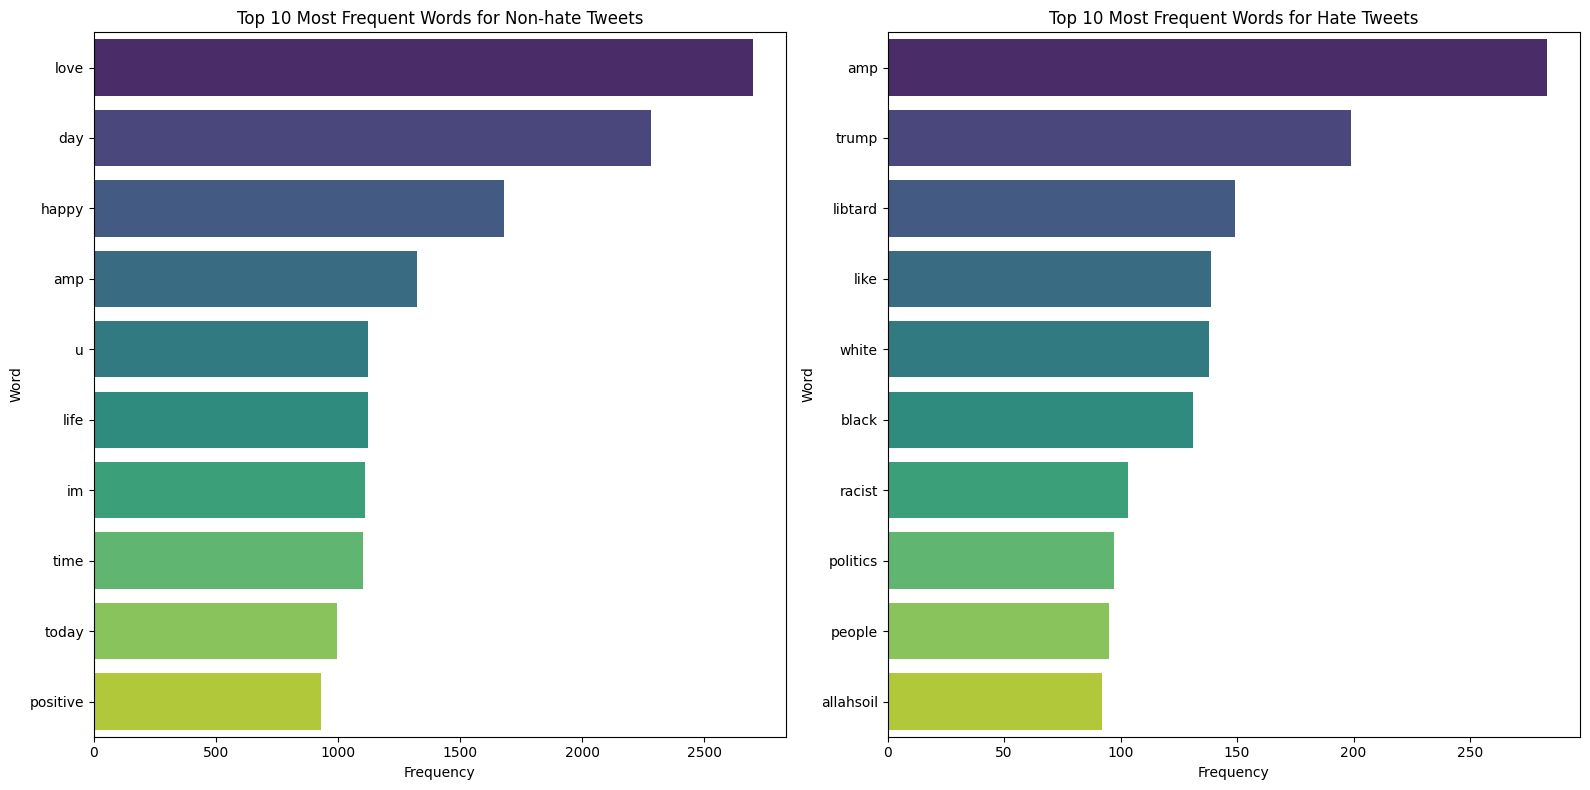

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

# top 10 frequent words in non-hate tweets
nonhate_top_words = word_counts_by_label[0].most_common(10)
nonhate_df = pd.DataFrame(nonhate_top_words, columns=['word', 'frequency'])
sns.barplot(x='frequency', y='word', data = nonhate_df,
            palette='viridis', ax=axes[0])
axes[0].set_title(f'Top 10 Most Frequent Words for Non-hate Tweets')
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Word')

# top 10 frequent words in hate tweets
hate_top_words = word_counts_by_label[1].most_common(10)
hate_df = pd.DataFrame(hate_top_words, columns=['word', 'frequency'])
sns.barplot(x='frequency', y='word', data = hate_df,
            palette='viridis', ax=axes[1])
axes[1].set_title(f'Top 10 Most Frequent Words for Hate Tweets')
axes[1].set_xlabel('Frequency')
axes[1].set_ylabel('Word')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

## 3.4 Word Cloud for each label

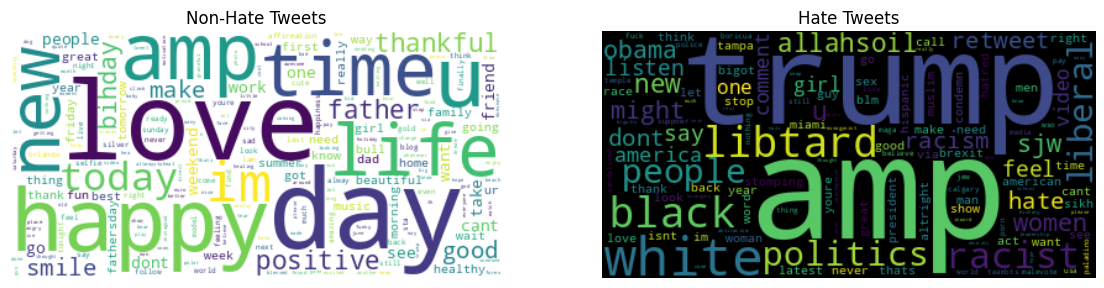

In [ ]:
fig, axs = plt.subplots(1,2 , figsize=(14,8))

# prepare the text data
non_hate = " ".join(speech['nostop_tweet'][speech['label'] == 0])
hate = " ".join(speech['nostop_tweet'][speech['label'] == 1])

# Word cloud for non-hate tweets
nonhate_cloud = WordCloud(collocations = False, background_color = 'white').generate(non_hate)
axs[0].imshow(nonhate_cloud, interpolation='bilinear')
axs[0].axis('off')
axs[0].set_title('Non-Hate Tweets')

# Word cloud for hate tweets
hate_cloud = WordCloud(collocations = False, background_color = 'black').generate(hate)
axs[1].imshow(hate_cloud, interpolation='bilinear')
axs[1].axis('off')
axs[1].set_title('Hate Tweets')

plt.show()

## 3.5 Check total number of hate speech and non-hate speech

In [ ]:
speech['label'].value_counts()

label
0    29720
1     2242
Name: count, dtype: int64

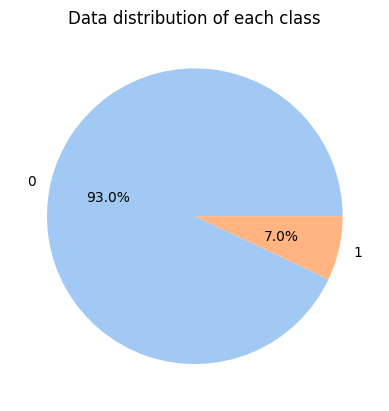

In [ ]:
data = speech['label'].value_counts()

fig, ax = plt.subplots()
ax.pie(data, labels=data.index, autopct='%1.1f%%', colors=sns.color_palette('pastel'))

# Set title and display
ax.set_title('Data distribution of each class')
plt.show()

It is obvious that the dataset is imbalanced, there are far more non-hate tweets than hate tweets. To solve this problem, we can resample hate speech samples with replacements (duplicate minority samples) to increasing the number of samples of hate tweets (label = 1).

## 3.6 Solve the imbalance issue

In [17]:
df_nohate = speech[speech.label == 0]
df_hate = speech[speech.label == 1]

# Upsample minority class
df_hate_upsampled = resample(df_hate,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_nohate),    # match number in majority class
                                 random_state=123)

# Combine non-hate tweet with upsampled hate tweet
speech_new = pd.concat([df_nohate, df_hate_upsampled])

# Display new class counts
print(speech_new['label'].value_counts())

label
0    29720
1    29720
Name: count, dtype: int64


In [18]:
speech_new.reset_index(drop = True, inplace = True)
speech_new.drop(columns = ['id'], inplace = True)

In [19]:
speech_new.isnull().sum()

label              0
tweet              0
nostop_tweet       0
tokenized_tweet    0
clean_tweet        0
dtype: int64

In [20]:
speech_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59440 entries, 0 to 59439
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   label            59440 non-null  int64 
 1   tweet            59440 non-null  object
 2   nostop_tweet     59440 non-null  object
 3   tokenized_tweet  59440 non-null  object
 4   clean_tweet      59440 non-null  object
dtypes: int64(1), object(4)
memory usage: 2.3+ MB


Now we have the same number of samples in each label, and there is no missing value in the dataset.

In [ ]:
speech_new.tail()

,label,tweet,nostop_tweet,tokenized_tweet,clean_tweet
59435,1,homicides rose in most big cities this year t...,homicides rose big cities year wall street jou...,"[homicides, rose, big, cities, year, wall, str...",homicide rose big city year wall street journa...
59436,1,the major kind of that people arent talking e...,major kind people arent talking enough via env...,"[major, kind, people, arent, talking, enough, ...",major kind people arent talking enough via env...
59437,1,he may be correct i just cant pay attention to...,may correct cant pay attention communist,"[may, correct, cant, pay, attention, communist]",may correct cant pay attention communist
59438,1,a look at the repug gop pay bigots at,look repug gop pay bigots,"[look, repug, gop, pay, bigots]",look repug gop pay bigot
59439,1,it is truly sad a who lot of working class men...,truly sad lot working class men resent offered...,"[truly, sad, lot, working, class, men, resent,...",truly sad lot working class men resent offered...


In [22]:
# save this new dataset as a csv file

file_path = '/content/drive/MyDrive/Data Glacier/Week 7-13: Hate Speech Detection Project (NLP)/speech_new.csv'

speech_new.to_csv(file_path, index = False)

# 4. Feature Extraction

## 4.1 Bag of Words (BoW)

This method converts text into a matrix of token counts (numerical representations), ignoring grammar and word order but keeping multiplicity. The intuition behind this method is that similar text fields will contain similar kind of words, therefore having similar bag of words.

It has three steps: the first step is **tokenization**, splitting the text into individual words and tokens; the second step is **vocabulary**, it creates a set of unique words (tokens) from the entire text corpus; the last step is **vectorization**, converting each document into a vector where each dimension corresponds to a word from the vocabulary and the value represents the word's frequency in the document.

In [ ]:
# select the top 4000 terms with the highest frequency
vectorizer = CountVectorizer(max_features = 4000)

# Fit and transform the text data
# learn the vocabulary and computes the term-document matrix

X = vectorizer.fit_transform(speech_new['clean_tweet'])

# Convert to array
X_array = X.toarray()

In [ ]:
# the first 10 vocabularies/features
vectorizer.get_feature_names_out()[:10]

array(['aampe', 'aande', 'aap', 'abe', 'abetting', 'able', 'ableism',
       'aboion', 'absolute', 'absolutely'], dtype=object)

In [ ]:
# BoW representation of the first 10 features
X_array[:10]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
X_array[0].shape

(4000,)

## 4.2 TF-IDF (Term Frequency - Inverse Document Frequency)

This method evaluates the importance of a word in a document relative to a collection of documents (corpus), reducing the weight of common words.


*   Term Frequency (TF): Measures how frequently a term occurs in a document. The assumption is that terms that appear more frequently within a document are more important.

$$TF(t, d) = \frac{\text{Number of term t appears in document d}}{\text{Total number of terms in document d}}$$

\\
*   Inverse Document Frequency (IDF): Measures how important a term is within the entire corpus. It helps to reduce the weight of terms that occur very frequently in many documents and increase the weight of terms that occur rarely.

$$IDF(t, D) = \log(\frac{\text{Total number of documents}}{\text{Number of documents containing term t}})$$

\\
*    The TF-IDF score is the product of TF and IDF:

$$TF-IDF(t, d, D) = TF(t, d) × IDF(t, D)$$

In [ ]:
vectorizer = TfidfVectorizer(max_features = 4000)
X = vectorizer.fit_transform(speech_new['clean_tweet'])

X.shape

(59440, 4000)

In [ ]:
# take the example of the first sample/tweets in the dataset
#  Convert the TF-IDF matrix of this sample to a DataFrame for better visualization

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(speech_new['clean_tweet'][0:1])

# Get the feature names
feature_names = vectorizer.get_feature_names_out()
df = pd.DataFrame(X.toarray(), columns=feature_names)
df.T

,0
drag,0.377964
dysfunction,0.377964
dysfunctional,0.377964
father,0.377964
kid,0.377964
run,0.377964
selfish,0.377964


## 4.3 Word Embeddings

This method represents words in a dense vector space, capturing semantic relationships. Words with similar meanings are located close to each other in this vector space.

Word embeddings are typically trained on large text corpora using neural networks. Here, we use the pre-trained `Word2Vec` models developed by Google (`GoogleNews-vectors-negative300.bin`), which contains vectors for a large vocabulary of around 3 million words and phrases. Each word vector is represented in a 300-dimensional space.

Twitter language is full of slang, abbreviations, and emojis. Word2Vec can learn these informal and evolving expressions, leading to accurate detection of hate tweets.

In [ ]:
model_path = '/content/drive/MyDrive/Colab Notebooks/DSO 560 Natural Language Processing/Homework/GoogleNews-vectors-negative300.bin'

# load the model
word2vec = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [ ]:
# prepare data
tokenized_data = speech_new['clean_tweet'].apply(word_tokenize)

# Convert Tokens to Vectors
def get_word_vectors(tokens, model):
    ''' Use the pre-trained Word2Vec model to get the vectors for each token.
    Handle words not in the vocabulary by skipping them.'''
    vector_size = model.vector_size
    vectors = []
    for token in tokens:
        if token in model:
            vectors.append(model[token])
        else:
            vectors.append(np.zeros(vector_size))
    return vectors

# Get word vectors for each tokenized sentence
word_vectors_data = [get_word_vectors(tokens, word2vec) for tokens in tokenized_data]

In [ ]:
# check the shape of each word vector
word_vectors_data[0][0].shape

(300,)

In [ ]:
# get the sentence vector (average the word vectors to get a single vector for the sentence)

def average_word_vectors(word_vectors):
    ''' average the word vectors to get a single vector
    representing the entire sentence'''
    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

# Compute the average word vector for each sentence
sentence_vectors = [average_word_vectors(word_vectors) for word_vectors in word_vectors_data]

In [ ]:
# the the check of each sentence vector
sentence_vectors[0].shape

Since we uses the Google Word2Vec model (GoogleNews-vectors-negative300.bin), each word vector is expected to have 300 dimensions.

In [ ]:
# from gensim.models import Word2Vec

# word2vec_model = Word2Vec(tokenized_data,
#                           vector_size=300,
#                           window=5, min_count=1, workers=4)

# def get_embedding(text):
#     ''' Use the pre-trained Word2Vec model to get the vectors for each token.
#     Handle words not in the vocabulary by skipping them.'''
#     tokens = word_tokenize(text)
#     # Filter out tokens that are not in the vocabulary
#     tokens = [token for token in tokens if token in word2vec_model.wv.key_to_index]
#     if len(tokens) > 0:
#         # Return the average of word embeddings for the tokens
#         return np.mean([word2vec_model.wv[t] for t in tokens], axis=0)
#     else:
#         return None

# # Create an array of embeddings for each text
# X_resampled = [get_embedding(text) for text in X_resampled]

## 4.4 BERT

**BERT** (Bidirectional Encoder Representations from Transformers) is a pre-trained transformer-based model designed for a wide range of NLP tasks. It is known for its ability to understand the context of a word in a sentence, reading text in both direction (left-to-right and right-to-left). Unlike traditional models that only look at a word's surrounding context in a single direction, BERT looks at the words that come before and after it.


*   **Transformer**: it applies self-attention mechanism, allowing the model to weight the importance of different words in a sentence when encoding a particular word. It enables the model to capture long-range dependencies.

*   **Positional Encoding**: Since transformers do not have any built-in notion of word order, positional encodings are added to the input embeddings to provide information about the position of each word in the sequence.

*   **Encoder**: it processes the input text and generates a contextualized representation. The original transformer model consists of an encoder and a decoder, BERT only use the encoder, its architecture involves stacking multiple transformer encoders, which allows it to build rich contextual representations of text. Each encoder layer consists of:

    *  *Multi-head self-attention mechanism*: it enables the model to focus on different parts of the sentence simultaneously, capturing various aspects of the relationships between words.

    *  *Feed-Forward Neural Networks (FFNN)*: it applies to each position separately and identically. FFNN layers introduces non-linearities and transforms the feature extracted by the self-attention mechanism, increasing the model's capacity to capture intricate relationships in the data.

    *  *Add and normalize operations for layer normalization and residual connections*: it stabilizes training and allows gradients to flow through the network more effectively.
    





In [23]:
speech_new = pd.read_csv(filepath + 'speech_new.csv')

In [24]:
# Load pre-trained model and tokenizer

# Since BERT requires inputs to follow a specific format
# it's better to tokanize data by using tokenizer in BertTokenizer package
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# load the model
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [29]:
speech_new['clean_tweet'].tolist()

['father dysfunctional selfish drag kid dysfunction run',
 'thanks lyft credit cant use cause dont offer wheelchair van pdx disapointed getthanked',
 'bihday majesty',
 'model love u take u time ur',
 'factsguide society motivation',
 'huge fan fare big talking leave chaos pay dispute get allshowandnogo',
 'camping tomorrow danny',
 'next school year year exam cant think school exam hate imagine actorslife revolutionschool girl',
 'love land allin cavs champion cleveland clevelandcavaliers',
 'welcome im gr',
 'ireland consumer price index mom climbed previous may blog silver gold forex',
 'selfish orlando standwithorlando pulseshooting orlandoshooting biggerproblems selfish heabreaking value love',
 'get see daddy today day gettingfed',
 'ouchjunior angrygot junior yugyoem omg',
 'thankful paner thankful positive',
 'friday smile around via ig user cooky make people',
 'know essential oil made chemical',
 'euro people blaming ha conceded goal fat rooney gave away free kick knowing bal

If receiving a batch of string that are too large, tokenizer cannot process at once. We need to process the tokenizer in small batch.

In [33]:
# Define a batch size
batch_size = 32

# Store the embeddings for all tweets
all_sentence_embeddings = []

In [44]:
# Process the tokenizer and get embedding in batches

for i in range(0, len(speech_new), batch_size):

    batch_texts = speech_new['clean_tweet'].astype(str).tolist()[i:i+batch_size]

    # Tokenize the batch
    inputs = tokenizer(batch_texts, return_tensors='pt', max_length=128,
                       padding=True, truncation=True)

    # Get the embeddings from BERT
    with torch.no_grad():
        outputs = bert_model(**inputs)

    # The embeddings are in the last hidden state
    embeddings = outputs.last_hidden_state

    # Average the token embeddings to get sentence embeddings
    sentence_embeddings = torch.mean(embeddings, dim=1)

    # Append the embeddings of the batch to the list
    all_sentence_embeddings.append(sentence_embeddings)

In [45]:
# Concatenate all batch embeddings into a single tensor

all_sentence_embeddings = torch.cat(all_sentence_embeddings, dim=0)

In [46]:
# Convert embeddings to numpy array

all_sentence_embeddings_np = sentence_embeddings.numpy()

In [48]:
all_sentence_embeddings_np[0].shape

(768,)

Each embedding vector has 768 dimensions, becuase the BERT base model produces embedding with a size of 768 for each token. Notice that we average the token embeddings of all words to get a single vector representing the entire tweet (sentence). It reduces the token-level embeddings to a single vector of the same dimensionality (768 dimension).

In [ ]:
# # Add the embeddings to the DataFrame
# speech_new['bert_embeddings'] = list(all_sentence_embeddings_np)